In [2]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
from io import BytesIO
from PIL import Image
import base64
import json
import PIL.Image
from torchvision import models, transforms
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
import torch
from skimage.transform import resize
import cv2
import requests

In [3]:
novaX = 46
novaY = 165
novaHeight = 90
novaWidth = 90

img = PIL.Image.open('../test_arm.jpg').convert('RGB')
tattoo_image = PIL.Image.open('C:\\Users\\lachl\\inkwell-ai\\flask-server\\images\\tiger-tattoo-design-with-japanese-decorative-style-transparent-illustration-png.png').convert('RGBA')

In [4]:
# Load the model from the .h5 file
model = load_model('model_with_background.h5')

In [24]:
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

def invert_colors(image):
    inverted_image = 255 - image
    return inverted_image

def overlay_images(background, overlay):
    # Create a copy of the background image to modify
    result = background.copy()

    # Resize the overlay image to match the background shape
    overlay_resized = overlay[:background.shape[0], :background.shape[1]]

    # Normalize the alpha values to range between 0 and 1
    overlay_alpha = overlay_resized[..., 3] / 255.0

    # Compute the weighted overlay using alpha blending
    result_alpha = 1 - (1 - overlay_alpha) * (1 - result[..., 3] / 255.0)
    result_alpha = np.clip(result_alpha, 0, 1)

    result[..., :3] = overlay_alpha[..., None] * overlay_resized[..., :3] + (1 - overlay_alpha[..., None]) * result[..., :3]
    result[..., 3] = result_alpha * 255

    return result

def convert_tattoo_to_rgba(image_array, alpha=255):
    # Check if the input image is already in RGBA format
    if image_array.shape[2] == 4:
        return image_array

    # Create an alpha channel with the specified value
    alpha_channel = np.full((image_array.shape[0], image_array.shape[1], 1), alpha, dtype=np.uint8)

    # Identify white pixels
    white_pixels = np.all(image_array == [1., 1., 1.], axis=-1)
    black_pixels = np.all(image_array == [0., 0., 0.], axis=-1)

    # Set alpha to 0 for white pixels
    alpha_channel[white_pixels] = 0
    alpha_channel[black_pixels] = int(0.8 * alpha)

    # Concatenate the alpha channel with the RGB image
    rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

    return rgba_array

### Making Predictions

In [6]:
img_np = np.array(img)

new_height = 1280
new_width = int(img_np.shape[1] / (img_np.shape[0] / new_height))
resized_image = cv2.resize(img_np, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
cropped_image = crop_image(resized_image, (1280, 720, 3))
resized_pre_image = resize(cropped_image, (160, 90, 3), mode='constant')

## Predict keypoint
from IPython.display import Image

# add an extra dimension for the batch
image_batch = np.expand_dims(resized_pre_image, axis=0)

# Make predictions
predictions = model.predict(image_batch)
# Reshape the predicted keypoints array to a (4, 2) matrix
predicted_keypoints = np.array(predictions).reshape((4, 2))

1/1 [==============================] - 0s 396ms/step


### Warping Tattoo

In [11]:
# Read Tattoo Image
from PIL import Image

scaled_tattoo = tattoo_image.resize((int(novaWidth), int(novaHeight)))

# Create a white background image to represent the arm
background_color = (255, 255, 255, 0)  # White color in RGB
background_image = Image.new("RGBA", (180, 320), background_color)

# Overlay the image onto the canvas using PIL
background_image.paste(scaled_tattoo, (novaX, novaY))

# Convert the final image to a NumPy array
image_array = np.array(background_image)

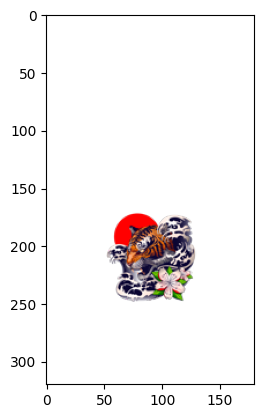

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.show()

In [18]:
# changing it to cv2
resized_image = resize(image_array, (320, 180, 4), mode='constant')
## Warp Tattoo Image

unnormalized_image = (resized_image * 255).astype(np.uint8)

# Binarize the image array
binarized_image_array = unnormalized_image

# making the keypoints for the flat arm
tl = (71, 137)
bl = (63, 320)
tr = (108, 137)
br = (121, 320)

pts1 = np.float32([tl, bl, tr, br])
pts2 = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]], [predicted_keypoints[3][0], predicted_keypoints[3][1]], [predicted_keypoints[1][0], predicted_keypoints[1][1]], [predicted_keypoints[2][0], predicted_keypoints[2][1]]])

matrix = cv2.getPerspectiveTransform(pts1, pts2)
transformed_frame = cv2.warpPerspective(binarized_image_array, matrix, (720, 1280))

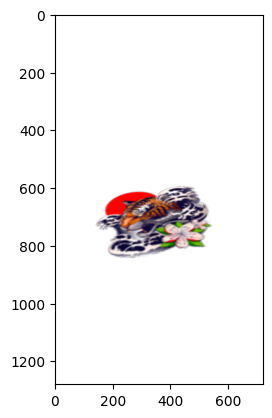

In [19]:
plt.imshow(transformed_frame)
plt.show()

In [28]:
normalized_image = transformed_frame / 255.0

rgba_arm = convert_tattoo_to_rgba(cropped_image)

overlaid_image = overlay_images(rgba_arm, transformed_frame)

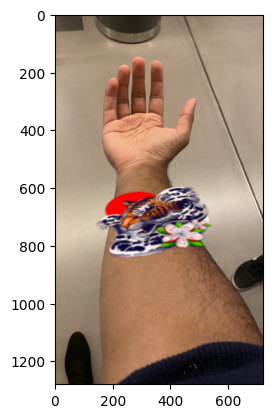

In [29]:
plt.imshow(overlaid_image)
plt.show()